<center>

<h1 style="font-size: 40px;">Q-Learning</h1>

</center>

The goal of the exercise is to implement the Q-learning algorithm with an epsilon-greedy action selection strategy. The algorithm should be applied to train an agent to solve the Cliff Walking problem, which is available in the Gymnasium package: [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/)

You should investigate the impact of the discount factor ($\lambda$) and the learning rate ($\beta$) on the algorithm.

In [1]:
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install ipython
%pip install gym
%pip install tabulate
%pip install ipywidgets
%pip install seaborn
%pip install imageio
%pip install ipympl
%pip install pygame
%matplotlib widget

import numpy as np
import gym
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')

def create_Qtable():
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    return Qtable

In [3]:
learning_rate = 0.5
epsilon = 0.5
gamma = 0.5
min_epsilon = 0.01
eps_decay = 0.8

We use an $\epsilon$-greedy action selection strategy.

In [4]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()

    else:
        return np.argmax(Qtable[state])

The main loop of the algorithm

In [5]:
def train(episodes, steps, Qtable, env, learning_rate, greedy_policy, gamma, epsilon, min_epsilon=0.01, eps_decay=0.8):
    rewards = []
    timesteps = []
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0
        episode_timestaps = 0

        for step in range(steps):
            action = greedy_policy(Qtable, state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            Qtable[state][action] = (1-learning_rate)*Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
            episode_reward += reward
            episode_timestaps += 1


            if done:
                break

            state = next_state

        epsilon = max(min_epsilon, np.exp(-eps_decay*epsilon))
        rewards.append(episode_reward)
        timesteps.append(episode_timestaps)

    return Qtable, rewards, timesteps

We choose the best path from the calculated Q-matrix.

In [6]:
def evaluate_agent(Q, env, episodes, steps):
    episodes_rewards = []
    episodes_timesteps = []
    episodes_penalties = []

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0
        episode_timestaps = 0
        episode_penalties = 0

        for step in range(steps):
            action = np.argmax(Q[state][:])
            next_state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            episode_timestaps += 1

            if reward == -100:
                episode_penalties += 1

            if done:
                break

            state = next_state

        episodes_rewards.append(episode_reward)
        episodes_timesteps.append(episode_timestaps)
        episodes_penalties.append(episode_penalties)

    return episodes_rewards, episodes_timesteps, episodes_penalties


Heatmaps used to illustrate dependencies.

In [7]:
def heatmap_lr_gamma(lr_values, gamma_values, iftimesteps=False):
    reward_matrix = np.zeros((len(lr_values), len(gamma_values)))
    timesteps_matrix = np.zeros((len(lr_values), len(gamma_values)))

    for i, lr in enumerate(lr_values):
        for j, gamma in enumerate(gamma_values):
            Qtable = np.zeros((env.observation_space.n, env.action_space.n))
            Qtable, rewards, timesteps = train(1000, 100, Qtable, env, lr, epsilon_greedy_policy, gamma, epsilon)

            mean_reward = np.mean(rewards)
            reward_matrix[i, j] = mean_reward

            mean_timesteps = np.mean(timesteps)
            timesteps_matrix[i, j] =  mean_timesteps

    if iftimesteps:
        sns.heatmap(timesteps_matrix, annot=True, xticklabels=gamma_values, yticklabels=lr_values, cmap="inferno")
    else:
        sns.heatmap(reward_matrix, annot=True, xticklabels=gamma_values, yticklabels=lr_values, cmap="inferno")
    plt.xlabel("Gamma")
    plt.ylabel("Learning Rate")
    if iftimesteps:
        plt.title("Mean timesteps")
    else:
        plt.title("Mean reward")
    plt.show()

    if iftimesteps:
        best_index = np.argmin(timesteps_matrix)
        best_lr_index = best_index // len(gamma_values)
        best_gamma_index = best_index % len(gamma_values)
        
        print("Best learning rate: ", lr_values[best_lr_index])
        print("Best gamma: ", gamma_values[best_gamma_index])
        print("Best mean timesteps: ", np.min(timesteps_matrix))
        
    else:
        best_index = np.argmax(reward_matrix)
        best_lr_index = best_index // len(gamma_values)
        best_gamma_index = best_index % len(gamma_values)
        
        print("Best learning rate: ", lr_values[best_lr_index])
        print("Best gamma: ", gamma_values[best_gamma_index])
        print("Best mean reward: ", np.max(reward_matrix))


In [8]:
def heatmap_eps_dec(eps_values, dec_values, learning_rate=0.5, gamma=0.5, min_epsilon=0.01, iftimesteps=False):
    reward_matrix = np.zeros((len(eps_values), len(dec_values)))
    timesteps_matrix = np.zeros((len(eps_values), len(dec_values)))

    for i, eps in enumerate(eps_values):
        for j, dec in enumerate(dec_values):
            Qtable = np.zeros((env.observation_space.n, env.action_space.n))
            Qtable, rewards, timesteps = train(1000, 100, Qtable, env, learning_rate, epsilon_greedy_policy, gamma, eps, min_epsilon, dec)
            
            mean_reward = np.mean(rewards)
            reward_matrix[i, j] = mean_reward

            mean_timesteps = np.mean(timesteps)
            timesteps_matrix[i, j] =  mean_timesteps

    if iftimesteps:
        sns.heatmap(timesteps_matrix, annot=True, xticklabels=dec_values, yticklabels=eps_values, cmap="inferno")
    else:
        sns.heatmap(reward_matrix, annot=True, xticklabels=dec_values, yticklabels=eps_values, cmap="inferno")
        
    plt.xlabel("Decay")
    plt.ylabel("Epsilon")
    if iftimesteps:
        plt.title("Mean timesteps")
    else:
        plt.title("Mean reward")
    plt.show()
    
    if iftimesteps:
        best_index = np.argmin(timesteps_matrix)
        best_eps_index = best_index // len(eps_values)
        best_dec_index = best_index % len(dec_values)
        
        print("Best epsilon: ", eps_values[best_eps_index])
        print("Best decay: ", dec_values[best_dec_index])
        print("Best mean timesteps: ", np.min(timesteps_matrix))
        
    else:
        best_index = np.argmax(reward_matrix)
        best_eps_index = best_index // len(eps_values)
        best_dec_index = best_index % len(dec_values)
        
        print("Best epsilon: ", eps_values[best_eps_index])
        print("Best decay: ", dec_values[best_dec_index])
        print("Best mean reward: ", np.max(reward_matrix))

In [9]:
Qtable = create_Qtable()
Qtable, rewards, timesteps = train(1000, 100, Qtable, env, learning_rate, epsilon_greedy_policy, gamma, epsilon)
rewards, timesteps, penalties = evaluate_agent(Qtable, env, 100, 100)

print("Mean reward: ", np.mean(rewards))
print("Standard deviation of reward: ", np.std(rewards))
print("Mean timesteps: ", np.mean(timesteps))
print("Standard deviation of timesteps: ", np.std(timesteps))
print("Mean penalties: ", np.mean(penalties))
print("Standard deviation of penalties: ", np.std(penalties))

c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Mean reward:  -13.0
Standard deviation of reward:  0.0
Mean timesteps:  13.0
Standard deviation of timesteps:  0.0
Mean penalties:  0.0
Standard deviation of penalties:  0.0


As we can see, the algorithm learned to find the appropriate path within 1000 episodes.

Now, let's focus on finding the appropriate values for the discount factor and the learning rate.

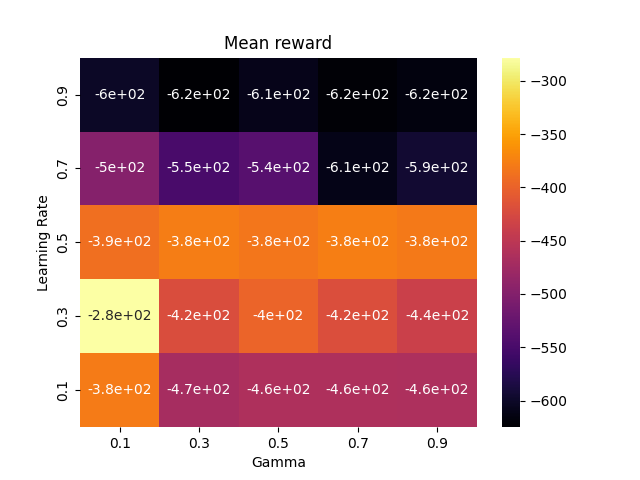

Best learning rate:  0.3
Best gamma:  0.1
Best mean reward:  -278.233


In [10]:
lr_values = [0.9, 0.7, 0.5, 0.3, 0.1]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

heatmap_lr_gamma(lr_values, gamma_values)

We can observe that the reward values are higher when we provide low coefficient values.

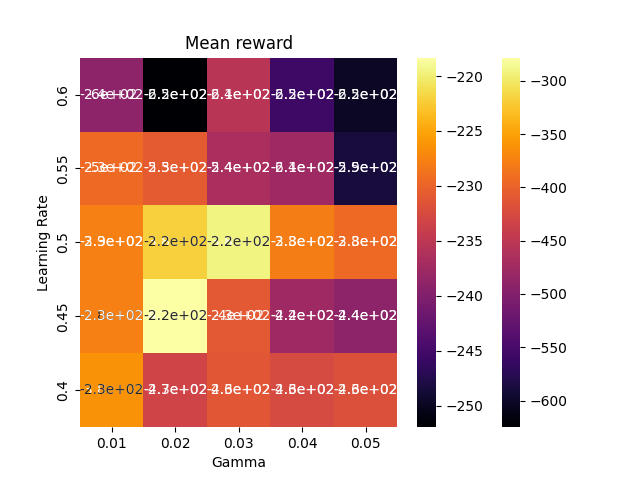

Best learning rate:  0.45
Best gamma:  0.02
Best mean reward:  -218.325


In [11]:
lr_values = [0.6, 0.55, 0.5, 0.45, 0.4]
gamma_values = [0.01, 0.02, 0.03, 0.04, 0.05]

heatmap_lr_gamma(lr_values, gamma_values)

More accurate values of coefficient.

Let’s now examine the relationship between the average number of steps and $\alpha$ and $\gamma$.

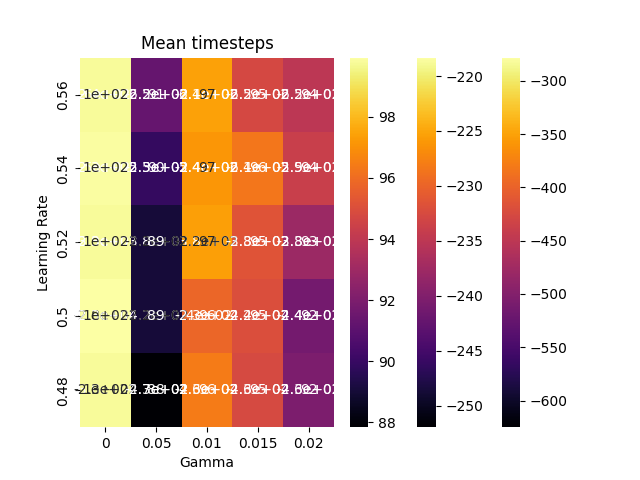

Best learning rate:  0.48
Best gamma:  0.05
Best mean timesteps:  87.845


In [12]:
lr_values = [0.56, 0.54, 0.52, 0.5, 0.48]
gamma_values = [0, 0.05, 0.01, 0.015, 0.02]

heatmap_lr_gamma(lr_values, gamma_values, iftimesteps=True)

We can observe that the smallest number of steps is obtained for $\gamma$=0.5.

Let’s now examine the relationship between the average reward and the value of $\epsilon$ and the decay coefficient of $\epsilon$.

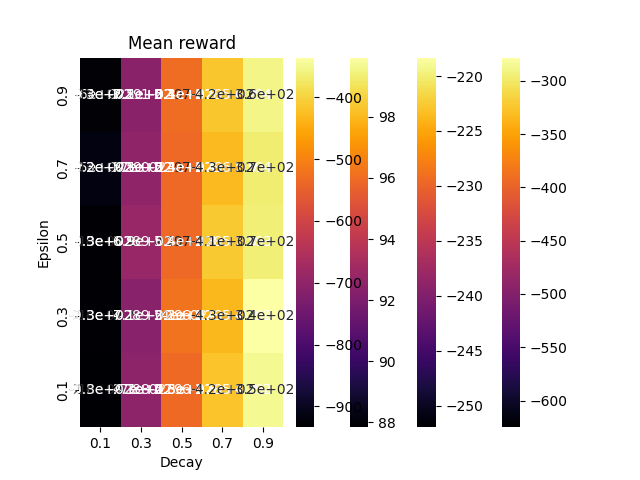

Best epsilon:  0.3
Best decay:  0.9
Best mean reward:  -336.028


In [13]:
learning_rate = 0.5
gamma = 0.03
eps_values = [0.9, 0.7, 0.5, 0.3, 0.1]
dec_values = [0.1, 0.3, 0.5, 0.7, 0.9]

heatmap_eps_dec(eps_values, dec_values)

We can observe that the algorithm makes fewer errors on average when the decay coefficient values of epsilon are high.

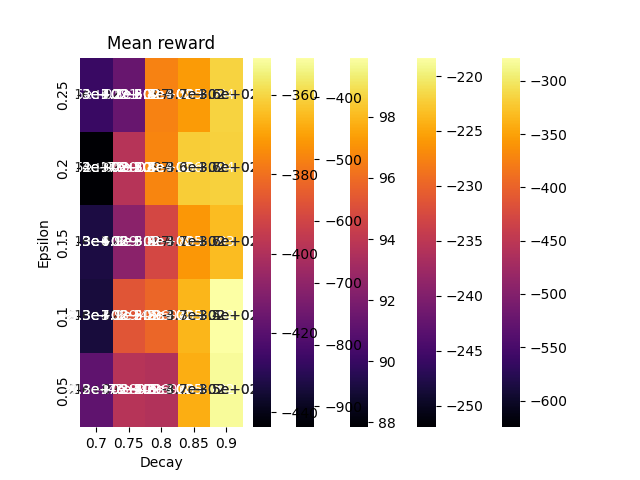

Best epsilon:  0.1
Best decay:  0.9
Best mean reward:  -350.606


In [14]:
learning_rate = 0.5
gamma = 0.03
eps_values = [0.25, 0.2, 0.15, 0.1, 0.05]
dec_values = [0.7, 0.75, 0.8, 0.85, 0.9]

heatmap_eps_dec(eps_values, dec_values)

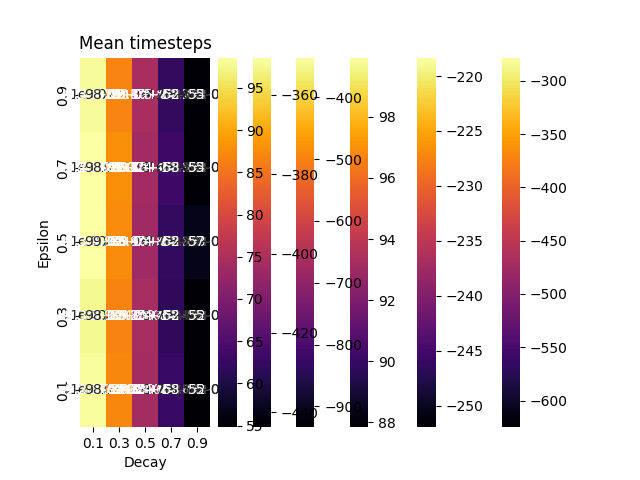

Best epsilon:  0.1
Best decay:  0.9
Best mean timesteps:  54.815


In [15]:
learning_rate = 0.5
gamma = 0.03
eps_values = [0.9, 0.7, 0.5, 0.3, 0.1]
dec_values = [0.1, 0.3, 0.5, 0.7, 0.9]

heatmap_eps_dec(eps_values, dec_values, iftimesteps=True)

When examining the average number of steps, we also notice that it is better for larger decay coefficient values.

In [13]:
def record_episode(Qtable, env, filename):
    Qtable = create_Qtable()
    Qtable, rewards, timesteps = train(1000, 100, Qtable, env, learning_rate, epsilon_greedy_policy, gamma, epsilon)
    state = env.reset()[0]
    done = False
    images = []

    while not done:
        images.append(env.render())
        action = np.argmax(Qtable[state])
        next_state, reward, done, truncated, info = env.step(action)

        if done:
            break
        
        state = next_state

    images.append(env.render())

    imageio.mimsave(filename, images, fps=3)

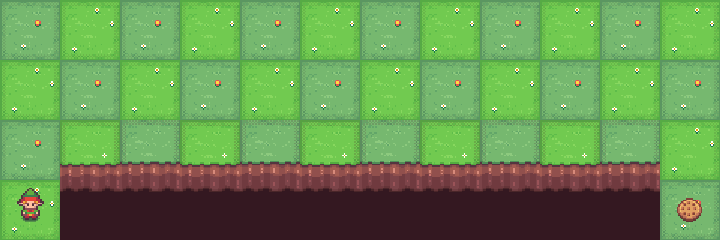

In [14]:
record_episode(Qtable, env, 'cliff_walkingQ.gif')
Image('cliff_walkingQ.gif')

Using the Q-learning algorithm, the agent traverses the path in the shortest possible way.

In [10]:
def solve_without_learning(env):
    env.reset()
    frames = []
    penalties, timeseps = 0, 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, done, truncated, info = env.step(action)

        if reward == -100:
            penalties += 1

        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward,
            'done': done
            }
        )
        timeseps += 1

    return frames, penalties, timeseps

In [11]:
def record_gif(frames, filename):
    i = len(frames) - 1
    while frames[i]['reward'] == -1:
        i -= 1
    with imageio.get_writer(filename, mode='I') as gif:
        for j, frame in enumerate(frames[i:]):
            frame = frame['frame']
            gif.append_data(frame)

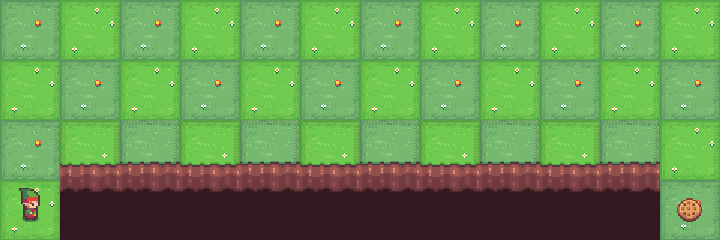

In [12]:
frames, penalties, timesteps = solve_without_learning(env)
record_gif(frames, 'cliffwalking.gif')

Image(open('cliffwalking.gif','rb').read())

Without using learning algorithms, the agent makes random moves until it eventually completes the board.

In [15]:
def agent_wo_learning(env, repeats):
    episodes_rewards = []
    episodes_timesteps = []
    episodes_penalties = []

    for i in range(repeats):
        frames, penalties, timesteps = solve_without_learning(env)
        sum_rewards = sum(frame['reward'] for frame in frames)
        episodes_rewards.append(sum_rewards)
        episodes_timesteps.append(timesteps)
        episodes_penalties.append(penalties)

    return episodes_rewards, episodes_timesteps, episodes_penalties

The comparison of average values for the Q-learning algorithm and random move selection.

In [16]:
Qtable = create_Qtable()
Qtable, rewards, timesteps = train(1000, 100, Qtable, env, learning_rate, epsilon_greedy_policy, gamma, epsilon)
Qrewards, Qtimesteps, Qpenalties  = evaluate_agent(Qtable, env, 100, 100)

rewards, timesteps, penalties = agent_wo_learning(env, 10)


data = {'Agent': ['Q-learning', 'Without Learning'],
    'Mean Reward': [np.mean(Qrewards), np.mean(rewards)],
    'Standard Deviation of Reward': [np.std(Qrewards), np.std(rewards)],
    'Mean Timesteps': [np.mean(Qtimesteps), np.mean(timesteps)],
    'Standard Deviation of Timesteps': [np.std(Qtimesteps), np.std(timesteps)],
    'Mean Penalties': [np.mean(Qpenalties), np.mean(penalties)],
    'Standard Deviation of Penalties': [np.std(Qpenalties), np.std(penalties)]}

df_comparison = pd.DataFrame(data)
df_comparison.set_index('Agent', inplace=True)
df_comparison


,Mean Reward,Standard Deviation of Reward,Mean Timesteps,Standard Deviation of Timesteps,Mean Penalties,Standard Deviation of Penalties
Agent,,,,,,
Q-learning,-13.0,0.000000,13.0,0.000000,0.0,0.000000
Without Learning,-125343.2,138843.654471,12087.2,13665.536461,1144.0,1264.468268


The results show that without using a learning algorithm, the average number of steps is enormous, which consequently takes a long time to reach the optimal point.